# Main Program to initialize the FPL Predictions

This is the main script for initializing and running FPL (Fantasy Premier League) predictions, using data from previous seasons to train models and make predictions for the current game week. The code is structured to load and process historical FPL data, train machine learning models (XGBoost or RandomForest), and use the trained models to make predictions for player performance. Finally, it optimizes a team selection based on predicted points and constraints.

### Breakdown of the Script:

#### 1. **Imports and Initial Setup**:
   - The script imports several libraries, including machine learning and deep learning tools (e.g., XGBoost, RandomForest, Keras), along with data processing and visualization libraries (Pandas, NumPy, Matplotlib).
   - It also imports modules specific to the FPL project, such as `FPLDataLoader`, `FPLDataProcessor`, and model trainer classes like `FPLModelTrainer_XG` and `FPLModelTrainer_RF`.

#### 2. **Loading Data**:
   - The script loads data from multiple FPL seasons (2024-25, 2023-24, 2022-23, 2021-22) using the `FPLDataLoader` class.
   - This step combines data across seasons, which is important for training the model on a larger dataset to improve prediction accuracy.
   - The data includes players, fixtures, player history, and teams.

#### 3. **Processing Data**:
   - The `FPLDataProcessor` class is used to clean and process the raw data.
   - The processed data includes key components:
     - `players`, `player_history`, `teams`, `fixtures`
     - Unique player identifiers (`players_unique`)
     - Important columns and overall averages for modeling
     - Fixture difficulty ratings (`fixture_difficulty`)
   
   This step ensures the data is in a usable format for model training and prediction.

#### 4. **Training the Model**:
   - The script offers two types of models for training:
     - **XGBoost**: Gradient boosting-based model.
     - **RandomForest**: A decision tree-based ensemble model.
   
   - The `train_model` function lets the user specify which model to use, the name of the model, and the game weeks from the current season to include in training.
   - For XGBoost, the `FPLModelTrainer_XG` class handles model training and updating using new data (including the latest game weeks).
   - For RandomForest, the `FPLModelTrainer_RF` class performs similar tasks.

   **Key Parameters**:
   - `model_type`: Either "XGBoost" or "RandomForest" for selecting the model.
   - `modelName`: The filename for saving the trained model (e.g., `FPL_XGboost_20241016.joblib`).
   - `seasonGames`: The current season games in the format `20242501`, `20242502`, etc., representing individual game weeks from the 2024-25 season.

   **Model Outputs**:
   - Predictions for each player’s performance (predicted points).
   - Evaluation metrics like Mean Absolute Error (MAE) and R-squared (R²) to measure model performance.
   - A trained model that can be saved and loaded for future use.

#### 5. **Prediction for the Current Game Week**:
   - After training the model, the script moves on to making predictions for the current game week.
   - It initializes the `FPLPredictionProcessor` to process and predict player performance for the upcoming game week (`CURRENT_GW = 8`).
   - Predictions include estimated points for each player, sorted in descending order to identify top performers.

#### 6. **Team Optimization**:
   - The final part of the script involves selecting the best FPL team for the upcoming game week using the `TeamOptimizer` class.
   - The optimizer selects players based on predicted points while adhering to constraints (e.g., budget, position limits).
   - It uses linear programming to optimize the team selection, returning the best lineup.

#### 7. **Display Results**:
   - The optimized team is displayed, showing the selected players for the upcoming game week, ranked by predicted points.

### Key Workflow:
1. **Load data** for past seasons.
2. **Process data** to ensure it's clean and ready for modeling.
3. **Train a model** (XGBoost or RandomForest) on historical data.
4. **Make predictions** for the upcoming game week using the trained model.
5. **Optimize the team** based on predicted points and display the best team selection.

### Summary:
This script sets up a full pipeline for FPL predictions, from data loading and cleaning to model training, prediction, and team optimization. It allows users to train models on historical data, make predictions for the current game week, and select an optimal team while meeting constraints like budget and position counts. The flexibility of choosing between XGBoost and RandomForest models gives the user options based on their preferences or specific needs for model performance.

In [11]:
#imports for all
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import time
from datetime import datetime
import os

# Load and Combine Seasons

- Specify the seasons to load data for in the loader

In [12]:
from data_loader import FPLDataLoader

# Create loader instance
loader = FPLDataLoader(['2024-25', '2023-24', '2022-23', '2021-22'])  # Specify seasons directly

# Get the data
data = loader.get_combined_data()

# Access individual dataframes from data loader - Needed later
players = data['players']
fixtures = data['fixtures']
player_ids = data['player_ids']
player_history = data['player_history']
teams = data['teams']

# Clean Data and Prep for Models

In [13]:
from data_processor import FPLDataProcessor

# Process the data
processor = FPLDataProcessor()
(players, player_history, teams, fixtures, 
 players_unique, required_columns, 
 overall_averages, fixture_difficulty) = processor.process_data(
    data['player_ids'], data['teams'], 
    data['players'], data['player_history'], 
    data['fixtures']
)

# Select the Model you want to use for training

- Currently two types XGboost and RandomForest
- Also specify the current seasons to include with training and the model name
    - If the model has already been run initially then choose the next seasons gameweek that was not included in the training

Start time: 10-21-2024 11:53:13
Model not found at XGboost_test.joblib. Training a new model.

Processing game week: 20242501
Performing initial model training with grid search...


/Users/kyle/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0, 'tree_method': 'hist'}
Best score:  -0.7143898221105575
MAE: 0.6830572981985114, R2: 0.7556726946960486
Training time: 98 minutes and 40.01 seconds for game week: 20242501

Processing game week: 20242502
Updating model...
MAE before update: 0.747388559874076


/Users/kyle/Documents/MyProjects/FPL /v2/XGBoost_trainer.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.74541041421093
MAE: 0.74541041421093, R2: 0.7479821745963091
Training time: 0 minutes and 0.49 seconds for game week: 20242502

Processing game week: 20242503
Updating model...
MAE before update: 0.6332037444291019


/Users/kyle/Documents/MyProjects/FPL /v2/XGBoost_trainer.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6330518323945338
MAE: 0.6330518323945338, R2: 0.7785421569156222
Training time: 0 minutes and 0.60 seconds for game week: 20242503

Processing game week: 20242504
Updating model...
MAE before update: 0.6845708261836659


/Users/kyle/Documents/MyProjects/FPL /v2/XGBoost_trainer.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6806517466902733
MAE: 0.6806517466902733, R2: 0.7350112192964648
Training time: 0 minutes and 0.48 seconds for game week: 20242504

Processing game week: 20242505
Updating model...
MAE before update: 0.6870619651954339


/Users/kyle/Documents/MyProjects/FPL /v2/XGBoost_trainer.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6871444816585754
MAE: 0.6871444816585754, R2: 0.7644115626840507
Training time: 0 minutes and 0.52 seconds for game week: 20242505

Processing game week: 20242506
Updating model...
MAE before update: 0.6882993867970947


/Users/kyle/Documents/MyProjects/FPL /v2/XGBoost_trainer.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6864028145047955
MAE: 0.6864028145047955, R2: 0.7347117683979412
Training time: 0 minutes and 0.69 seconds for game week: 20242506

Processing game week: 20242507
Updating model...
MAE before update: 0.7411896883547753


/Users/kyle/Documents/MyProjects/FPL /v2/XGBoost_trainer.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.7395413120736604
MAE: 0.7395413120736604, R2: 0.719245173264246
Training time: 0 minutes and 0.66 seconds for game week: 20242507
Overall MAE: 0.6936085571044684
Overall R2: 0.7479395356929547


/Users/kyle/Documents/MyProjects/FPL /v2/XGBoost_trainer.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


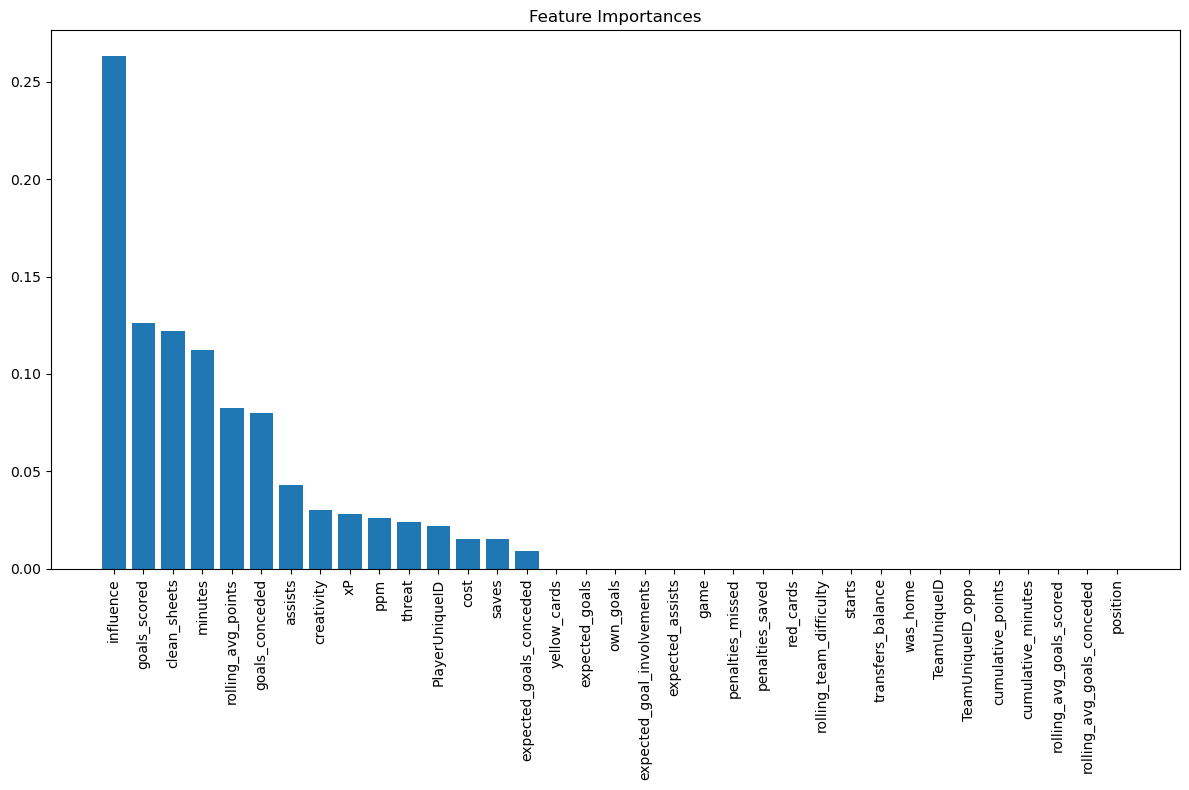

Model saved as XGboost_test.joblib


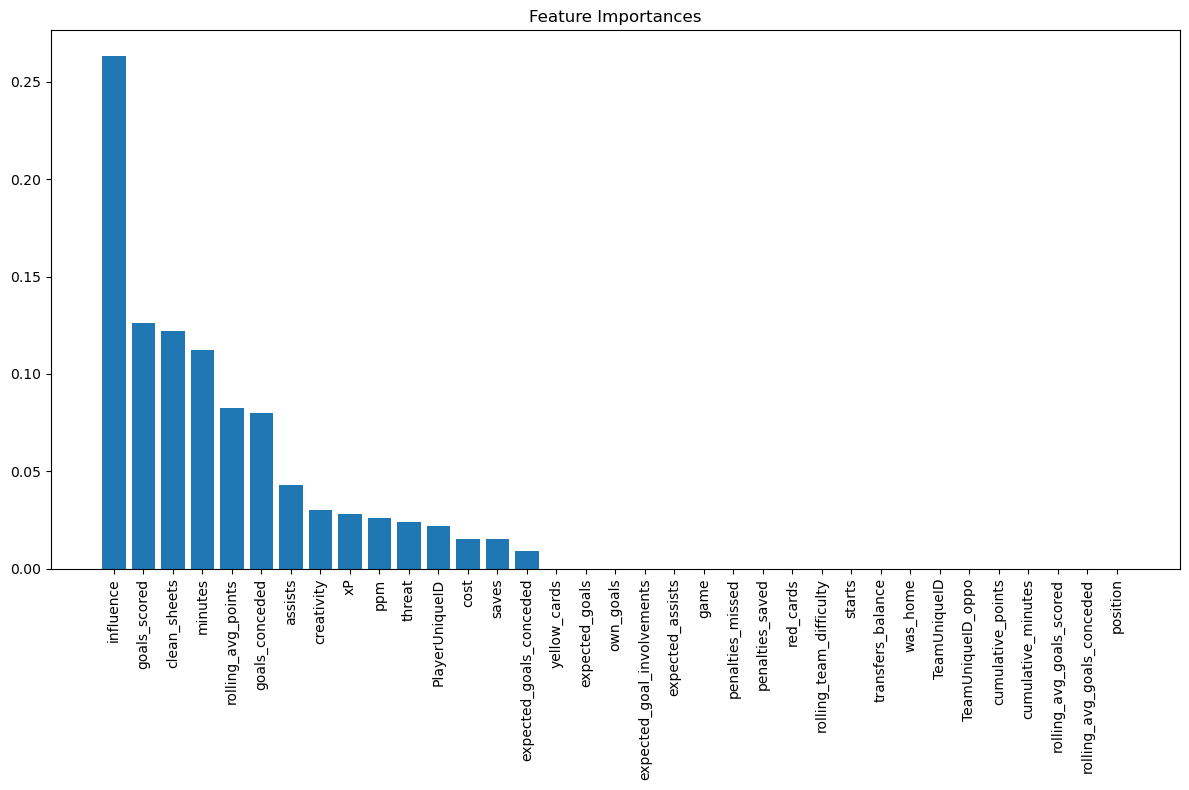

In [14]:
#Configuration for XGBoost model

# Define model name and current season games to train on
model_name = "XGboost_test.joblib"
current_season_games = ['20242501', '20242502', '20242503', '20242504', '20242505', '20242506', '20242507']


#####################################################################################################################
#####################################################################################################################
from XGBoost_trainer import FPLModelTrainer_XG
from config import (features, target)
# Initialize components
trainer = FPLModelTrainer_XG(model_name)
# Train and evaluate model
predictions, overall_mae, overall_r2, final_model = trainer.train_and_update(
    player_history, features, target, current_season_games
)
# Load model and plot feature importance
loaded_model = trainer.load_model()
trainer.plot_feature_importance(loaded_model, features)

Start time: 10-21-2024 10:41:44
Model not found at RandomForest_test.joblib. Training a new model.

Processing game week: 20242501
Performing initial model training with grid search...


/Users/kyle/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  -0.10184222365651836
MAE: 0.09513560819407106, R2: 0.9718661933041961
Training time: 64 minutes and 42.11 seconds for game week: 20242501

Processing game week: 20242502
Updating model...
MAE before update: 0.09830199699328211


/Users/kyle/Documents/MyProjects/FPL /v2/randomForest_trainer.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.08486402887736508
MAE: 0.08486402887736508, R2: 0.9875942467131761
Training time: 0 minutes and 12.25 seconds for game week: 20242502

Processing game week: 20242503
Updating model...
MAE before update: 0.08592212484411305


/Users/kyle/Documents/MyProjects/FPL /v2/randomForest_trainer.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.06219561083280216
MAE: 0.06219561083280216, R2: 0.9856255231934014
Training time: 0 minutes and 12.33 seconds for game week: 20242503

Processing game week: 20242504
Updating model...
MAE before update: 0.08636987563512984


/Users/kyle/Documents/MyProjects/FPL /v2/randomForest_trainer.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.06140228803580268
MAE: 0.06140228803580268, R2: 0.9869292013244934
Training time: 0 minutes and 12.55 seconds for game week: 20242504

Processing game week: 20242505
Updating model...
MAE before update: 0.09311078860741719


/Users/kyle/Documents/MyProjects/FPL /v2/randomForest_trainer.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.06793462767386096
MAE: 0.06793462767386096, R2: 0.9878564289756423
Training time: 0 minutes and 12.49 seconds for game week: 20242505

Processing game week: 20242506
Updating model...
MAE before update: 0.09427853468208336


/Users/kyle/Documents/MyProjects/FPL /v2/randomForest_trainer.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.06419671706441289
MAE: 0.06419671706441289, R2: 0.9899826792156506
Training time: 0 minutes and 12.55 seconds for game week: 20242506

Processing game week: 20242507
Updating model...
MAE before update: 0.1198568345969718


/Users/kyle/Documents/MyProjects/FPL /v2/randomForest_trainer.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.07486439553901338
MAE: 0.07486439553901338, R2: 0.9863116227627606
Training time: 0 minutes and 12.78 seconds for game week: 20242507
Overall MAE: 0.07294189660247545
Overall R2: 0.9851665564984743


/Users/kyle/Documents/MyProjects/FPL /v2/randomForest_trainer.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


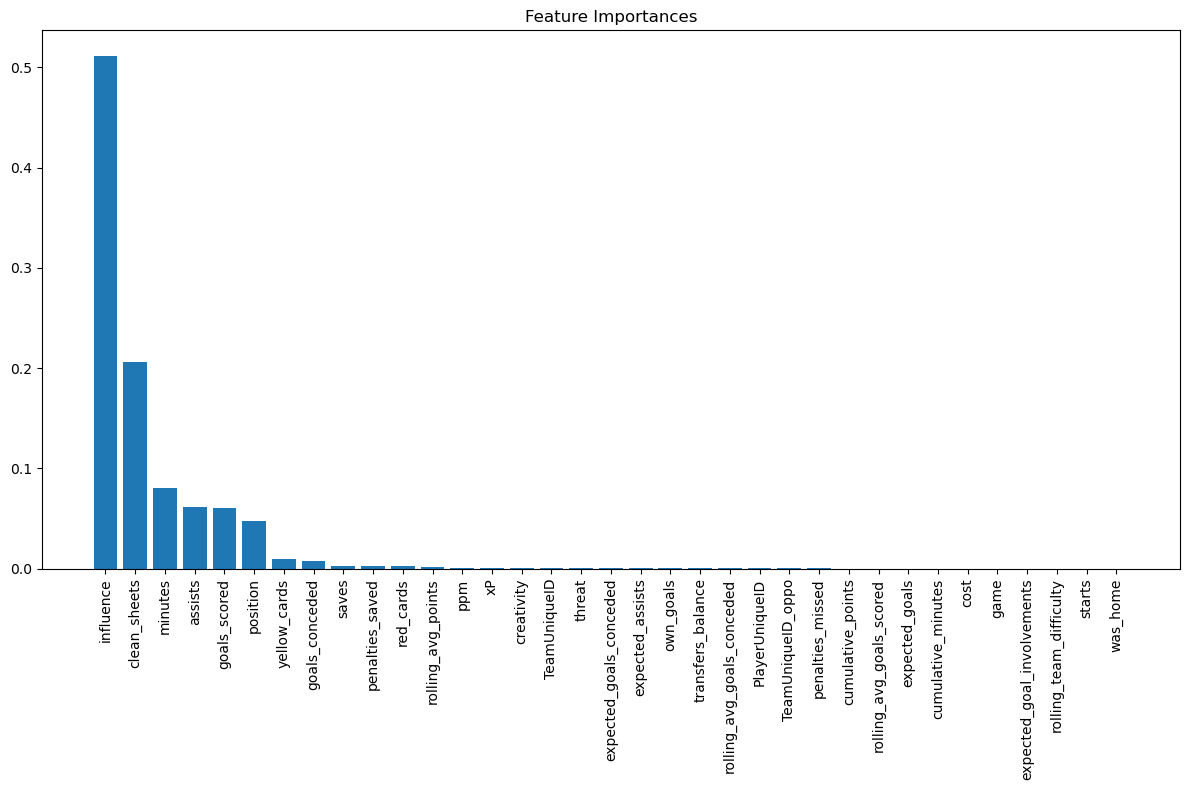

Model saved as RandomForest_test.joblib


In [4]:
# Configuration for Random Forest model

# Define model name and current season games to train on
model_name = "RandomForest_test.joblib"
current_season_games = ['20242501', '20242502', '20242503', '20242504', '20242505', '20242506', '20242507']



#####################################################################################################################
#####################################################################################################################
from randomForest_trainer import FPLModelTrainer_RF
from config import (features, target)

# Run the training
predictions, overall_mae, overall_r2, final_model = FPLModelTrainer_RF(
    player_history, 
    features, 
    target, 
    current_season_games,
    model_name
)

# Load Current Gameweek Data and Create Predictions
    - enter the CURRENT_GW
    - current season is set in the config file

In [15]:
from fplPredictions import FPLPredictionProcessor

#set the current game week, need to set the current gameweek in the config file
#CURRENT_GW = 8

# Initialize the processor
processor = FPLPredictionProcessor(model_name) #model name set above in the model selection step

# Process and get predictions
# Note: You need to have teams and players_unique data available
predictions = processor.process_and_predict(teams, players_unique)

# View top 20 predictions
if predictions is not None:
    print("Next weeks predictions processed")

Next weeks predictions processed


# Select Best Team For the Gameweek

In [16]:

from team_optimizer import TeamOptimizer

# Initialize the optimizer
optimizer = TeamOptimizer()

# Get optimized team
optimized_team = optimizer.optimize(predictions, teams, budget=100)

# Display results
print(optimized_team)

           Team                        Player Position  Player Cost  \
2   Aston Villa                 Ollie Watkins      FWD          9.1   
4       Chelsea               Nicolas Jackson      FWD          7.9   
5       Chelsea                   Cole Palmer      MID         10.8   
7       Everton                 Dwight McNeil      MID          5.6   
10    Liverpool                 Mohamed Salah      MID         12.7   
13        Spurs               Brennan Johnson      MID          6.5   
1       Arsenal                   Kai Havertz      FWD          8.3   
11     Man City                 Mateo Kovačić      MID          5.5   
8     Leicester                  James Justin      DEF          4.5   
0       Arsenal  Gabriel dos Santos Magalhães      DEF          6.2   
14       Wolves               Rayan Aït-Nouri      DEF          4.4   
9     Liverpool               Ibrahima Konaté      DEF          5.2   
3     Brentford                Nathan Collins      DEF          4.5   
12    

In [22]:
#Example Random Forest Output

#RandomForest_optimized_team= optimized_team
#print(RandomForest_optimized_team)

              Team                            Player Position  Player Cost  \
2      Bournemouth                        Lewis Cook      MID          5.0   
1      Aston Villa                      Amadou Onana      MID          5.1   
0          Arsenal                     Thomas Partey      MID          5.0   
9         Man City                     Mateo Kovačić      MID          5.5   
11     Southampton                 Sugawara Yukinari      DEF          4.5   
12           Spurs                       Pedro Porro      DEF          5.5   
14          Wolves                      Mario Lemina      MID          5.0   
5   Crystal Palace                        Marc Guéhi      DEF          4.4   
7        Leicester                      James Justin      DEF          4.5   
8        Liverpool                   Ibrahima Konaté      DEF          5.2   
6          Ipswich                        Liam Delap      FWD          5.6   
3        Brentford                       Yoane Wissa      FWD   

In [19]:
#Example XGBoost Output

#XGboost_optimized_team = optimized_team
#print(XGboost_optimized_team)

           Team                        Player Position  Player Cost  \
2   Aston Villa                 Ollie Watkins      FWD          9.1   
4       Chelsea               Nicolas Jackson      FWD          7.9   
5       Chelsea                   Cole Palmer      MID         10.8   
7       Everton                 Dwight McNeil      MID          5.6   
10    Liverpool                 Mohamed Salah      MID         12.7   
13        Spurs               Brennan Johnson      MID          6.5   
1       Arsenal                   Kai Havertz      FWD          8.3   
11     Man City                 Mateo Kovačić      MID          5.5   
8     Leicester                  James Justin      DEF          4.5   
0       Arsenal  Gabriel dos Santos Magalhães      DEF          6.2   
14       Wolves               Rayan Aït-Nouri      DEF          4.4   
9     Liverpool               Ibrahima Konaté      DEF          5.2   
3     Brentford                Nathan Collins      DEF          4.5   
12    